# Principal Component Analysis (PCA)

**Nombres y Apellidos:** *Escriba aqui*

En este taller implementaremos el algoritmo de PCA desde cero. Los principales tópicos que revisaremos son:

- Implementación del algoritmo de PCA.
- Reducción de dimensionalidad de un conjunto de datos 2D a 1D.
- Aplicación sobre el conjunto de datos de flores de iris.
- Selección del número de componentes principales.
- Uso de implementación de la librería scikit-learn.
- Aplicación sobre un conjunto de datos tabular.

Empecemos importando las librerías:

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

## Implementación de PCA

A continuación realizaremos la implementación de PCA, para ello es necesario seguir los siguientes pasos:

1. Estandarizar el data (standardize).
2. Calcular la matriz de covarianza para las características.
3. Calcular los autovalores y autovectores de la matriz de covarianza.
4. Ordenar los autovalores y sus correspondientes autovectores.
5. Seleccionar 'k' autovectores
6. Transformar la data original

### Data de Prueba

Para probar nuestra implementación, haremos uso de datos generados simples para poder visualizarlos.

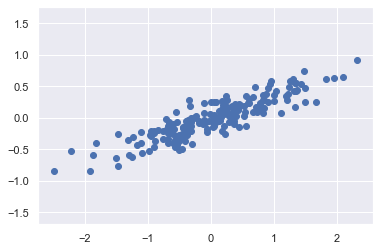

In [2]:
# Especificamos un random state para reproducir la generación de la data
rng = np.random.RandomState(1)
# Esta es la data con que se deberá probar la implementación
X = np.dot(rng.rand(2, 2), rng.randn(2, 200)).T
# Visualizamos la data
plt.scatter(X[:, 0], X[:, 1])
plt.axis('equal');

In [9]:
X.shape

(200, 2)

### Estandarizar la data

Estandarizamos la data para que la distribución de cada característica tenga una media igual a cero y una desviación estándar igual uno (varianza unitaria).

$$X_{new} = \frac{X - \mu}{ \sigma }$$

Es importante recalcar que algunas implementaciones y librerías no escalan sus datos para tener una varianza unitaria, por lo tanto, solamente realizan el centrado de datos ($X - \mu$).

In [50]:
def standardize(X):
    """Estandarizar el dataset X -> (X - mean) / std
    Args:
        X: dataset de dimensión (N x D), donde D es la dimensión de la data,
            y N el número de puntos.
    
    Returns:
        (X_norm, mu, std): X_norm es la data estandarizada con media 0
        y desviación estándar 1; mu y std son la media y desviación estándar
        respectivamente.
    
    Note:
        Es probable que encuentres dimensiones donde la desviación estándar es 0,
        y ello implica una división por cero (NaN). Para manejar ese escenario,
        cuando reemplaza la desviación estándar de 0 por 1 antes de estandarizar.
    """
    # Calcular la media y desviación estandar
    mu = np.mean(X,axis=0)
    std = np.std(X,axis=0)
    print("stdddd: ",std)
    # Reemplazar los valores de std=0 con 1
    std_filled= std.copy()
    std_filled[std==0] = 1
    print("std_ fileld: ",std_filled)
    # Estandarizar la data
    X_norm  =(X-mu)/std
    return X_norm, mu, std_filled

Estandarizamos la data de prueba y obtenemos la data estandarizada, la media y desviación estándar:

In [51]:
X_norm, mu, std = standardize(X)

print("Media", mu)
print("Desviación Estándar", std)

print("Media de la nueva data: ", X_norm.mean(0))
print("Desviación Estándar de la  nueva data: ", X_norm.std(0))

stdddd:  [0.823873   0.31358832]
std_ fileld:  [0.823873   0.31358832]
Media [ 0.03351168 -0.00408072]
Desviación Estándar [0.823873   0.31358832]
Media de la nueva data:  [-1.77635684e-17 -4.44089210e-18]
Desviación Estándar de la  nueva data:  [1. 1.]


Algo importante a mencionar es que cuando tenemos dos conjuntos de datos, por ejemplo, entrenamiento y test. Hallamos la média y desviación estándar de la data de entrenamiento y usamos esa média y desviación estándar para estandarizar la data de test. Un proceso similar veremos cuando reduzcamos la dimensionalidad.

### Calcular la matriz de covarianza para las características

La matriz de covarianza para un dataset de dimensión $(N, D)$ está dada por:

$$ Cov(X) = \frac{1}{N - 1}(X - \bar{X})^T(X - \bar{X}) $$

donde $\bar{X}$ es la media de cada característica.
En el paso anterior hemos escalado los datos para que tengan media 0, por tanto la matriz de covarianza se reduce a lo siguiente:

$$ Cov(X) = \frac{1}{N - 1}X^{T}X$$

In [52]:
def covariance_matrix(X):
    """Calculamos la matriz de covarianza de X
      Args:
          X: dataset de dimensión (N x D), donde D es la dimensión de la data,
             y N el número de puntos.
      
      Returns:
          cov: matriz de covarianza de dimensión (D x D).
    """
    cov = np.cov(X)
    return cov

Mostramos los resultados de la matriz de covarianza:

In [53]:
S = covariance_matrix(X_norm)
# Mostramos la matriz de covarianza
print("Matriz de covarianza")
print(S)

# Mostramos los resultados a partir de la libreria de numpy
print("\nMatriz de covarianza - numpy")
# numpy recibe una matriz de (D, N) dimensiones por tanto
# la convarianza se calcula cov = XX^T
print(np.cov(X_norm.T))

Matriz de covarianza
[[ 0.03654507  0.10434726 -0.06807994 ... -0.03853645  0.01880842
  -0.04815528]
 [ 0.10434726  0.29794303 -0.19438885 ... -0.11003324  0.05370373
  -0.13749792]
 [-0.06807994 -0.19438885  0.12682635 ...  0.07178968 -0.03503827
   0.08970864]
 ...
 [-0.03853645 -0.11003324  0.07178968 ...  0.04063634 -0.01983331
   0.05077931]
 [ 0.01880842  0.05370373 -0.03503827 ... -0.01983331  0.00968001
  -0.02478377]
 [-0.04815528 -0.13749792  0.08970864 ...  0.05077931 -0.02478377
   0.063454  ]]

Matriz de covarianza - numpy
[[1.00502513 0.89385925]
 [0.89385925 1.00502513]]


### Autovalores y autovectores de la matriz de covarianza

Recordemos que los autovectores representan las componentes principales que generan el subespacio sobre el cual proyectaremos nuestra data y los autovalores la varianza explicada o retenida por cada componente. Matemáticamente es posible calcular los autovalores y autovectores resolviendo el siguiente sistema de ecuaciones:

$$Ab = \lambda b$$

donde $A$ es la matriz sobre la cual deseamos obtener los autovalores y autovectores, $b$ son los autovectores (eigenvectors) y $\lambda$ son los autovalores (eigenvalues). En nuestro caso, calcularemos los autovectores y autovalores de la matriz de covarianza, es decir, la matriz $A$ representa la matriz de covarianza. Para facilitar el proceso, haremos uso de una implementación de la librería de algebra lineal, [linalg](https://numpy.org/doc/1.18/reference/generated/numpy.linalg.eig.html#numpy.linalg.eig), que permite calcular los autovalores y autovectores de una determinada matriz cuadrada, como la matriz de covarianza es cuadrada (D x D), es posible usar esa implementación.

En esta parte haremos los pasos $3$ y $4$ al mismo tiempo: 

3. Calcular los autovalores y autovectores de la matriz de covarianza.
4. Ordenar los autovalores y sus respectivos autovectores.

Tomar en consideranción que la líbreria retorna un vector con los autovalores y una matriz con los autovectores, donde cada columna es un autovalor y autovector respectivamente.

In [70]:
def eig(S):
    """Calcular los autovalores y sus correspondientes autovectores de la 
       matriz de covarianza S.
    Args:
        S: matriz de covarianza de dimensión (D, D)
    
    Returns:
        (eigvals, eigvecs): los autovalores (1, D) y autovectores (D, D)

    Note:
        los autovalores y autovectores deben ser ordenados en orden descendente
        con respecto a los autovalores
    """
    # Calcular los autovalores y autovectores la matriz de covarianza S
    # usar el método np.linalg.eig para facilitar el proceso 
    eigvals, eigvecs =np.linalg.eig(S)

    # Ordenar los autovalores y sus correspondientes autovectores 
    # Puede hacer uso de np.sort o np.argsort para ordenar los vectores
    eigvals=np.sort(eigvals)
    eigvecs =np.sort( eigvecs)
    # * Tomar en cuenta que la primera columna de la matriz de autovalores,
    #   corresponde con la primera columna de la matriz de autovectores
    
    return (eigvals, eigvecs)

Mostramos los autovalores y autovectores respectivos. Los autovalores deben estar ordenados de mayor a menor.

In [ ]:
eigvals, eigvecs = eig(S)

for i in range(len(eigvals)):
    print("Autovalor %d: %lf" % (i+1, eigvals[i]))
    print("Autovector %d: " % (i+1))
    print(eigvecs[:,i].reshape(1,len(eigvals)).T)
    print(40 * '-')

Ahora visualizemos los autovectores que representan las componentes sobre las cuales proyectaremos nuestra data:

ValueError: operands could not be broadcast together with shapes (2,) (200,) 

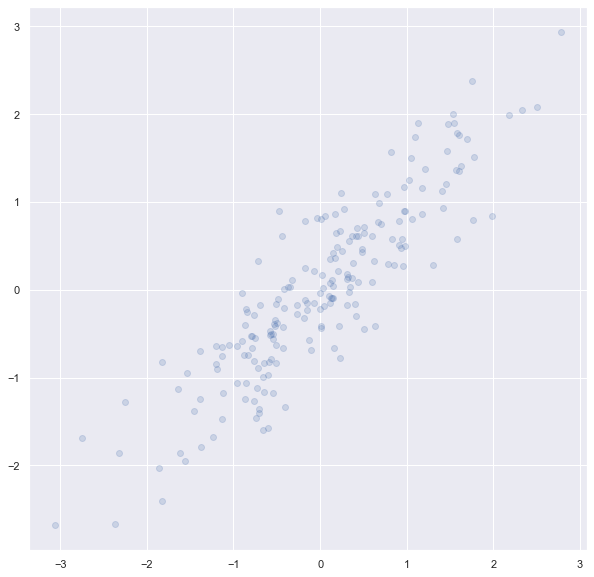

In [72]:
plt.figure(figsize=(10,10))
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0, color='r')
    ax.annotate('', v1, v0, arrowprops=arrowprops)

# plot data
plt.scatter(X_norm[:, 0], X_norm[:, 1], alpha=0.2)
mu_center = X_norm.mean(0)
for i in range(len(eigvals)):
    # solo para efectos de visualizar, aumentamos la magnitud de los autovectores
    vector  = eigvecs[:,i] * np.sqrt(eigvals[i])*2
    draw_vector(mu_center, mu_center + vector)
plt.axis('equal');    

La longitud de cada autovector (autovalor) es un indicador de importancia de cada autovector en el nuevo eje de coordenadas. La primera componente siempre representará la mayor varianza proyectada de los datos. 

### Proyección usando todas las componentes

Podemos realizar la proyección usando el nuevo eje de coordenadas obtenido a partir de los autovectores, es decir, usaremos todos los autovectores para la proyección en el subespacio (nuevo eje de coordenadas). Más adelante realizaremos la proyección sobre un menor subespacio. Para ello, la proyección de nuestra data sobre los vectores que generan el nuevo subespacio (autovectores) esta data por:

$$T = XB$$

donde $B$ es la matriz columna de autovectores donde proyectaremos nuestra data y $T$ es la transformación de nuestra data original de un espacio vectorial origen a un subespacio vectorial destino dado por los autovectores. En otras palabras, $T$ es la proyección de nuestra data sobre las componentes principales (nuevo eje de coordenadas).



In [78]:
X_norm.shape

(200, 2)

In [80]:
eigvecs.shape

(200, 200)

In [75]:
def transform_full(X, B):
    """Transformar la data X al nuevo eje de coordenadas generado por B.
    Args:
        X: dataset (N, D)
        B: matriz columna de autovectores (D, D)

    Returns:
        T: dataset transformado sobre el nuevo eje de coordenadas (N, D)
    """  
    T=X.dot(B)
    return T

Visualizamos la data en el nuevo eje de coordenadas

In [76]:
T = transform_full(X_norm, eigvecs)

plt.figure(figsize=(10,10))
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0, color='r')
    ax.annotate('', v1, v0, arrowprops=arrowprops)

# plot data
def pca_2d_plot(T, title='Principal Components'):
    plt.scatter(T[:, 0], T[:, 1], alpha=0.2)
    draw_vector([0, 0], [0, 1])
    draw_vector([0, 0], [1, 0])
    plt.axis('equal');
    plt.gca().set(xlabel='component 1', ylabel='component 2',
            title=title,
            xlim=(-4, 4), ylim=(-2, 2))

pca_2d_plot(T)

ValueError: shapes (200,2) and (200,200) not aligned: 2 (dim 1) != 200 (dim 0)

Como podemos observar, el eje de coordenadas ha sido rotado en base a los autovectores y la data ha sido proyectada sobre el nuevo eje de coordenadas. A continuación haremos la proyección usando solo algunas componentes.

### Reducción de Dimensionalidad

En la sección anterior vimos la transformación de la data de un espacio vectorial inicial, a un subespacio generado por **todos** los autovectores también llamados componentes principales. Ahora realizaremos el mismo proceso pero considerando solamente **algunos** autovectores. Como los autovectores están ordenados con respecto a sus autovalores, las primeras componentes capturarán la mayor varianza de la data, por tanto cuando reduzcamos la dimensionalidad de $D$ a $K$, siempre tomaremos en consideramos los primeros $K$ autovectores.

$$T = X\hat{B}$$

donde $T$ es la transformación del espacio vectorial de nuestra data a un subespacio generado solamente por los $K$ primeros autovectores y $\hat{B}$ es una matriz de dimensionalidad (D, K), es decir, una submatriz de $B$ que considera solamente las primeras $K$ columnas.

In [ ]:
def transform_data(X, B, K):
    """Transformar la data X al nuevo eje de coordenadas generado por B
       considerando las primeras K columnas de B.
    Args:
        X: dataset (N, D)
        B: matriz columna de autovectores (D, D)
        K: número de componentes a considerar en la transformación

    Returns:
        T: dataset transformado sobre el nuevo eje de coordenadas (N, K)
        B_k: matriz columna de los primeros K autovectores (D, K)
    """  
    B_k = 
    T = 
    return T, B_k

Es importante mencionar que en la función anterior estamos retornando la data con dimensionalidad reducida y los primeros $K$ autovectores que generan el subespacio reducido. Al igual que cuando escalamos nuestros datos (standardize), donde calculamos la media y desviación estándar solo sobre la data de entrenamiento y las usamos en la data de test, la matriz de autovectores se calcula solamente sobre la data de entrenamiento y se usa esa matriz para reducir la dimensionalidad de la data de test.


Mostremos los resultados de la transformación:

In [ ]:
X_pca, B_k = transform_data(X_norm, eigvecs, 1)

print("Dimensión de data original: ", X_norm.shape)
print("Dimensión de data transformada: ", X_pca.shape)

print("\n Dimensión de la matriz de transformación: ", B_k.shape)

Visualizamos la data transformada:

In [ ]:
plt.figure(figsize=(10,10))

def pca_1d_plot(T, title='Principal Components'):
  # plot data
  plt.scatter(T[:, 0], np.zeros(T.shape[0]))
  plt.axis('equal');
  plt.gca().set(xlabel='component 1',
          title=title,
          xlim=(-4, 4), ylim=(-3, 3))
pca_1d_plot(X_pca)

Como podemos observar hemos transformado nuestra data de 2 dimensiones a 1 sola dimensión. La dimensión elegida es la que retiene la mayor varianza de los datos.

### Reconstrucción de la data

En la sección anterior hemos reducido la dimensionalidad de la data a una dimensión. Para entender mejor el efecto de esta reducción, podemos realizar la reconstrucción de la data mediante la transformación inversa de la data reducida, es decir, hallar la inversa de la matriz de autovectores y usarla para volver al eje de coordenadas inicial. Entonces tendremos lo siguiente:

$$P = X\hat{B}{\hat{B}}^{-1} = T\hat{B}^{-1}$$

donde $T$ es la transformación que usamos para reducir la dimensionalidad, $\hat{B}$ es la matriz conteniendo las primeras $K$ componentes y $\hat{B}^{-1}$ es la matriz inversa de $\hat{B}$. Debido a que $B$ es una matriz ortogonal, se cumple que:

$$ \hat{B}^{-1} = \hat{B}^T$$

por lo tanto la reconstrucción de la data sobre el eje de coordenadas inicial esta dado por:

$$P = X\hat{B}{\hat{B}}^{T} = T\hat{B}^{T}$$

In [ ]:
def inverse_transform(T, B_k):
    """Reconstruir la data inicial a partir de la data transformada,
       aplicando la transformación inversa de las componentes.

    Args:
        T: dataset transformado sobre el nuevo eje de coordenadas (N, K)
        B_k: matriz columna de los primeros K autovectores (D, K)

    Returns:
        X_rec: dataset reconstruído (N, D)
    """      
    X_rec = 
    return X_rec


Mostremos los resultados de la transformación inversa:

In [ ]:
X_rec = inverse_transform(X_pca, B_k)

print("Dimensión de data reducida: ", X_pca.shape)
print("Dimensión de data recuperada: ", X_rec.shape)

Visualicemos la data reconstruida:

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(X_norm[:, 0], X_norm[:, 1], alpha=0.3)
plt.scatter(X_rec[:, 0], X_rec[:, 1], alpha=0.8, color='blue')
plt.axis('equal');

Los puntos claros son los datos originales, mientras que los puntos oscuros son lo datos reconstruidos o proyectados. Esto muestra de manera más clara lo que significa una reducción de dimensionalidad de PCA, ya que se elimina la información a lo largo del eje o ejes principales menos importantes, dejando solo el o los componente(s) de los datos con la mayor varianza. La fracción de varianza que se corta (proporcional a la extensión de puntos sobre la línea formada en esta figura) es aproximadamente una medida de cuánta "información" se descarta en esta reducción de dimensionalidad.

### Método Genérico para PCA

En las secciones anteriores hemos implementado PCA paso a paso. Ahora encapsularemos todo ese proceso en un solo método que recibirá como entrada la data estandarizada y el número de componentes, y retornará la data en una dimensionalidad reducida.

In [ ]:
def PCA(X, K):
    """Reducción de dimensionalidad de un conjunto de datos X usando K 
       componentes

    Args:
        X: dataset (N, D), se asume que la data ya está estandarizada
        K: número de componentes a considerar en la transformación

    Returns:
        T: dataset transformado sobre el nuevo eje de coordenadas (N, K)
        B_k: matriz columna de los primeros K autovectores (D, K)
    """ 
    # 1. Calcular la matriz de covarianza para las características
    

    # 2. Calcular los autovalores y autovectores de la matriz de covarianza


    # 3. Seleccionar 'K' autovectores y transformar la data original
    T, B_k = 

    return T, B_k

Probemos la implementación mediante visualizaciones para $K = 1$ y $K = 2$. Las visualizaciones deben de ser las mismas que las mostradas en pasos anteriores

In [ ]:
# Obtenemos data reducida 2D
T2, _= PCA(X_norm, 2)

# Obtenemos data reducida 1D
T1, _= PCA(X_norm, 1)

# Visualización
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
pca_2d_plot(T2, "Principal Components 2D")
plt.subplot(1, 2, 2)
pca_1d_plot(T1, "Principal Components 1D")

### PCA usando Singular Value Decomponsition (SVD)

Anteriormente hemos implementado PCA haciendo uso de descomposión espectral (Eigendecomposition). En este parte del taller, haremos uso de SVD, el cual es una forma más simple y eficiente de implementar debido a que podemos obtener directamente los autovectores y autovalores de la matriz de covarianza, además de tener los autovalores ya ordenados de mayor a menor. SVD descompone una matriz de cualquier dimensión (N, D) en tres matrices:

$$ X = U S V^T$$

donde $U$ es una matriz ortogonal que contiene los autovectores de la matriz $XX^T$, $S$ es una matriz diagonal que contiene los autovalores de la matriz $X^TX$ y $V$ es una matriz ortogonal que contiene los autovectores de la matriz $X^TX$. Como en nuestro problema estamos interesados en hallar los autovectores y autovalores de la matriz de covarianza ($X^TX$), entonces podemos usar SVD para obtenerlos directamente. Los pasos para reducir la dimensionalidad haciendo uso de SVD son:

1. Estandarizar o centrar la data.
2. Descomponer la matriz que representa la data ($X$) haciendo uso de SVD.
3. Como la matriz $V$ contiene los autovectores de la matriz de covarianza, hallamos la transpuesta de la matriz que retorna SVD. Tener en cuenta que la última matriz de SVD es $V^T$ pero nosotros necesitamos $V$.
4. Aplicar la transformación de $X$ haciendo uso de las primeras $K$ columnas de $V$ ($T$ = $X\hat{V}$) de la misma forma que hicimos en secciones anteriores.

Para descomponer la matriz haremos uso de la librería de [linalg](https://numpy.org/doc/1.18/reference/generated/numpy.linalg.svd.html) que nos retorna las $3$ matrices antes mencionadas. Tomar en consideranción que la líbreria retorna $S$ como un vector.

In [ ]:
def PCA_SVD(X, K):
    """Reducción de dimensionalidad haciendo uso de SVD sobre un 
       conjunto de datos X usando K componentes

    Args:
        X: dataset (N, D), se asume que la data ya está estandarizada
        K: número de componentes a considerar en la transformación

    Returns:
        T: dataset transformado sobre el nuevo eje de coordenadas (N, K)
        V_k: matriz columna de los primeros K autovectores (D, K)
    """ 
    # 1. Descomponer la matriz X haciendo uso de np.linalg.svd
    U, S, Vt = 
    
    # 2. Obtener la matriz 'V' que contiene los autovectores de la matriz de covarianza
    V = 

    # 3. Seleccionar K autovectores y transformar la data original
    T, V_k = 

    return T, V_k  

Probemos la implementación mediante visualizaciones para $K=1$ y $K=2$. Las visualizaciones deben de ser las mismas que las mostradas en pasos anteriores

In [ ]:
# Obtenemos data reducida 2D
T2, _= PCA_SVD(X_norm, 2)

# Obtenemos data reducida 1D
T1, _= PCA_SVD(X_norm, 1)

# Visualización
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
pca_2d_plot(T2, "Principal Components 2D")
plt.subplot(1, 2, 2)
pca_1d_plot(T1, "Principal Components 1D")

### Reducir la dimensionalidad a partir de las matrices $U$ y $S$ (opcional)

Es posible reducir la dimensionalidad haciendo uso de las matrices $U$ y $S$ de SVD. Para ello, usaremos propiedades de matrices ortogonales. Para empezar, nosotros sabemos que la matriz $V$ contiene los autovectores de la matriz de covarianza $X^TX$ y para transformar nuestros datos al nuevo subespacio formado por los autovectores (reducir dimensionalidad), simplemente tenemos que usar la matriz $V$, es decir, $$T = XV$$

Además, tenemos que la descomposición en valores singulares (SVD) esta dada por:

$$X = USV^T$$

combinamos ambas formulaciones, multiplicando $V$ en SVD:

$$XV = USV^TV$$ 

debido a que $V$ es una matriz ortogonal, tenemos que: $V^TV = I$, donde $I$ es la matriz identidad. Por lo tanto:

$$XV = US$$

ya que $XV$ es nuestra transformación al nuevo subespacio donde podemos reducir la dimensionalidad, podemos concluir que para reducir la dimensionalidad en base a $U$ y $S$ basta con multiplicarlos.

$$T = US$$

Esta forma de reducir la dimensionalidad es aplicada en el método `fit_transform` de la implementación de la librería `scikit-learn`. Tener en cuenta que esta tranformación solo se aplica en la data de entrenamiento, para la data de test aún es necesaria la matriz $V$. por ello en la siguiente implementación aplicaremos la transformación sobre $X$ pero la matriz $\hat{V}$ debe ser retornada de la misma forma que lo hicimos anteriormente, es decir, hallar la transpuesta de $V^T$ y seleccionar las primeras $K$ columnas ($\hat{V}$).

In [ ]:
def PCA_SVD2(X, K):
    """Reducción de dimensionalidad haciendo uso de SVD sobre un 
       conjunto de datos X usando K componentes

    Args:
        X: dataset (N, D), se asume que la data ya está estandarizada
        K: número de componentes a considerar en la transformación

    Returns:
        T: dataset transformado sobre el nuevo eje de coordenadas (N, K)
        V_k: matriz columna de los primeros K autovectores (D, K)
    """ 
    # 1. Descomponer la matriz X haciendo uso de np.linalg.svd
    U, S, Vt = 
    
    # 2. Transformar la data haciendo uso de la matriz U (N,N) y el vector
    #    S (N)
    T = 
    
    # 3. Obtener la matriz 'V' que contiene los autovectores de la matriz de covarianza
    V = 

    # 4. Seleccionar K autovectores
    V_k = 
    
    return T, V_k 

Probemos la implementación mediante visualizaciones para $K=1$ y $K=2$. Las visualizaciones deben de ser las mismas que las mostradas en pasos anteriores

In [ ]:
# Obtenemos data reducida 2D
T2, _ = PCA_SVD2(X_norm, 2)

# Obtenemos data reducida 1D
T1, _ = PCA_SVD2(X_norm, 1)

# Visualización
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
pca_2d_plot(T2, "Principal Components 2D")
plt.subplot(1, 2, 2)
pca_1d_plot(T1, "Principal Components 1D")

## Aplicación sobre el conjunto de datos de iris

En esta sección aplicaremos la implementación previamente realizada sobre el conjunto de datos de [iris](https://archive.ics.uci.edu/ml/datasets/Iris). El dataset contiene $150$ muestras de $3$ clases (setosa, versicolor y virginica) y $4$ características (largo del sépalo, ancho del sépalo, largo del pétalo, ancho del pétalo).

In [ ]:
### Cargando el dataset
from sklearn import datasets
iris = datasets.load_iris()

# conjunto de datos
X = iris.data

# etiquetas
y = iris.target

### Particionamiento de Datos

Como no contamos con un conjunto de datos de prueba (test), particionaremos los datos usando hold-out.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print('Train size: ', X_train.shape, 'Test size: ', X_test.shape)

Como tenemos $4$ características, no podemos visualizar directamente la data. Por ello, usaremos PCA para reducir la dimensionalidad y visualizar la data en un menor espacio de características. Por el momento mostraremos algunas filas de los datos:

In [ ]:
print("Algunos datos de entrenamiento")
print(X_train[0:5])

print("\nAlgunas etiquetas del dataset")
print(y_train[0:5])

### Estandarizar la Data

El primer paso antes de realizar PCA es estandarizar la data

In [ ]:
X_train_norm, X_train_mu, X_train_std = standardize(X_train)

print("Algunos datos de entrenamiento estandarizados")
print(X_train_norm[0:5])

Usaremos la media y desviación estándar calculadas en la data de entrenamiento para estandarizar la data de test

In [ ]:
# TODO: Estandarizar la data X_test usando X_train_mu y X_train_std
X_test_norm = 

print("Algunos datos de test estandarizados")
print(X_test_norm[0:5])

### Reducción de dimensionalidad

Usaremos nuestra implementación de PCA para reducir la dimensionalidad de los datos. El primer paso es usar la data de entrenamiento para calcular la matriz de componentes principales, $B$, la cual será usada para proyectar la data de test, de forma similar a lo que hicimos en la estandarización.

In [ ]:
# TODO: Usar el método PCA, previamente implementado, para reducir la 
# dimensionalidad de la data de entrenamiento a 2 dimensiones y obtener 
# la matriz de componentes principales
X_train_pca, B_train = 

print("Dimensión de data de entrenamiento original: ", X_train_norm.shape)
print("Dimensión de data de entrenamiento transformada: ", X_train_pca.shape)
print("Dimensión de matriz de componentes: ", B_train.shape)

Usaremos la matriz de componentes calculada en la data de entrenamiento para reducir la dimensionalidad de la data de test

In [ ]:
# TODO: Reducir la dimensionalidad de la data de test estandarizada
# (X_test_norm) usando la matriz de componentes B_train.
# Recordar que la transformación es una multiplicación de matrices
X_test_pca = 

print("Dimensión de data de test original: ", X_test_norm.shape)
print("Dimensión de data de test transformada: ", X_test_pca.shape)

### Visualización 

A diferencia del inicio, donde nuestra data original posee $4$ características, podemos usar la data transformada en $2$ dimensiones para visualizarla.

In [ ]:
def visualizar_iris_dataset(X_train, y_train, X_test, y_test):
    plt.subplots(figsize =(15, 5))
    plt.subplot(1, 2, 1)
    for i in range(0,3):    
        plt.scatter(X_train[y_train==i,0], X_train[y_train==i,1])
    plt.title('Train Dataset')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.legend(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'])

    plt.subplot(1, 2, 2)
    for i in range(0,3):    
        plt.scatter(X_test[y_test==i,0], X_test[y_test==i,1])
    plt.title('Test Dataset')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.legend(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'])
    plt.show()    

visualizar_iris_dataset(X_train_pca, y_train, X_test_pca, y_test)

### Seleccionando el Número de Componentes Principales

Una parte vital del uso de PCA en la práctica es la capacidad de estimar cuántas componentes se necesitan para describir los datos. Esto se puede determinar observando el **ratio o porcentaje de la varianza retenida** en función del número de componentes. Por ello, usaremos los autovalores obtenidos a partir de la matriz de covarianza, ya que los autovalores determinan la varianza retenida por cada componente de manera individual. Por lo tanto, el ratio individual de cada componente está dado por:

$$r_i = \frac{\lambda_i}{ \sum_{i=0}^K \lambda_i} $$

donde $\lambda_i$ es el autovalor correspondiente al $i$-ésimo autovector, $K$ es el número de componentes principales y $r_i$ el ratio de cada componente. Como nuestros autovalores están ordenados de mayor a menor, el primer autovalor es el valor de la mayor varianza retenida por el primer autovector, el segundo autovalor es el valor de la segunda mayor varianza retenida por el segundo autovector, etc. Por lo tanto, el ratio $r_1$ posee la mayor varianza retenida, el ratio $r_2$ posee la segunda mayor varianza retenida, etc. Como el ratio es un valor normalizado de los autovalores, tenemos que:

$$ R = \sum_{i=0}^K r_i = 1 $$

es decir, si uso todas las componentes tenemos que: $R = 1$, lo cual me indica que estoy reteniendo toda la varianza de mi data. Si uso menos componentes, el valor del ratio acumulado, $R$, se irá reduciendo. Como mi objetivo es mantener lo más posible la variabilidad de mis datos en un dimensión reducida, entonces vamos a buscar un $R$ con un valor cercano a $1$, por ejemplo: $0.96$, $0.98$, etc. En la práctica se suelen considerar valores $\geq0.95$, también es bueno hacer visualizaciones de la varianza retenida.


Debido a que nuestra implementación del método PCA no retorna la lista de autovalores, haremos una implementación independiente. Sin embargo, es muy recomendable implementar todo lo anterior en una clase ya que es más fácil adicionar componentes como el que tenemos ahora. Como este es un tutorial de implementación, procederemos con métodos. Más adelante usaremos la implementación de la librería por lo que no habrá problemas.

In [ ]:
def retained_variance(X):
    """Varianza retenida de manera individual y acumulada de las componentes 
       principales. 
       
       Para calcular la varianza retenida normalizada (ratio):
            retained_var(i) = autovalor(i)/ Σ(autovalores)
       Para calcular la varianza retenida normalizada acumulada:
            cum_retained_var(i) = Σ retained_var(0,i),
       es decir, suma acumulada de retained_var del indice 0 al indice actual i

    Args:
        X: dataset (N, D), se asume que la data ya está estandarizada

    Returns:
        retained_var: lista con la varianza retenida de cada componente (D)    
        cum_retained_var: lista con la varianza retenida acumulada (D)

    """ 
    # Calcular la matriz de covarianza para las características
    cov = 

    # Calcular los autovalores y autovectores de la matriz de covarianza
    (eigvals, eigvecs) =

    # Calcular el ratio individual de la varianza retenida usando los autovalores.
    # En este método el ratio 'r_i' lleva el nombre de 'retained_var' ya que el 
    # ratio es la varianza retenida normalizada
    retained_var = 

    # Calcular el varianza retenida acumulada, puede hacer uso del método np.cumsum
    cum_retained_var = 

    return retained_var, cum_retained_var

Probamos la implementación anterior:

In [ ]:
retained_var, cum_retained_var = retained_variance(X_train_norm)

print("Varianza retenida normalizada (ratio)")
print(retained_var)
print("Varianza retenida acumulada")
print(cum_retained_var)

Visualizamos la varianza retenida:

In [ ]:
def visualize_retained_variance(retained_var):
    y_pos = np.arange(len(retained_var))
    x_label = [ "PC%d"%(pos+1) for pos in y_pos]
    plt.figure(figsize=(8,5))
    plt.bar(y_pos, retained_var, align='center')
    plt.xticks(y_pos, x_label)
    plt.ylabel('Varianza retenida') 
    plt.title('Varianza retenida por componente principal')
    plt.show()

visualize_retained_variance(retained_var)    

Visualizamos la varianza retenida acumulada:

In [ ]:
def visualize_cumulative_retained_variance(cum_retained_var):
    y_pos = np.arange(len(cum_retained_var))
    x_label = [ "PC%d"%(pos+1) for pos in y_pos]
    plt.figure(figsize=(8,5))
    plt.plot(y_pos, cum_retained_var, marker='o')
    plt.xticks(y_pos, x_label)
    plt.ylabel('Varianza retenida') 
    plt.title('Varianza retenida por componente principal')
    plt.show()

visualize_cumulative_retained_variance(cum_retained_var*100) 

Como podemos observar en las gráficas anteriores, usando solo la primera componente principal retenemos el $70\%$ de la varianza de nuestros datos, con las primeras dos componentes retenemos más del $95\%$. Sin embargo, la tercera y cuarta componente no son del todo útiles en términos de la varianza retenida. Por lo tanto, podemos concluir que usando solamente dos componentes es suficiente para retener la mayor parte de la varianza de la data.

Finalmente, implementaremos el método que nos devolverá el número de componentes que retengan una varianza acumulada ingresada:

In [ ]:
def number_of_components(cum_retained_var, desired_var):
    """Número de componentes que retengan la varianza deseada dada por 
       'desired_var'. Es necesario usar 'cum_retained_var' para definir el
       número de componentes

    Args:
        cum_retained_var: lista con la varianza retenida acumulada(D)
        desired_var: valor entre 0 y 1 indicando la varianza deseada

    Returns:
        num_components: Número de componentes que retienen la varianza deseada

    """    
    num_components = 0
    for i, cum_var in enumerate(cum_retained_var):
        if cum_var <= desired_var:
           num_components = i + 1
        else:
           break
    return num_components

Probemos el método implementado:

In [ ]:
percentage = 0.95
num_components = number_of_components(cum_retained_var, percentage)

print("%d components retienen una varianza acumulada <= %lf" % (num_components, percentage) )

## PCA - Librería scikit-learn

Existen librerías que ya tienen una implementación de PCA. Es muy recomendable usar estas librerías por que son probadas por varios desarrolladores y usadas en múltiples productos. En esta oportunidad usaremos la implementación de [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html). Para ello importamos la librería:

In [ ]:
from sklearn.decomposition import PCA

Revisando la documentación podemos encontrar que PCA está implementado mediante Singular Value Decomposition (SVD) y posee diferentes atributos a los que podemos acceder:

| Atributo | Descripción | 
|--|--|
|  components_ | matriz de autovectores(eigenvectors)|
|  explained_variance_ | varianza retenida por cada componente|
|  explained_variance_ratio_ | varianza retenida normalizada por cada componente|
|  mean_ | media de la data antes de centrarla |

Como podemos observar, todos los atributos los hemos implementado y solamente cambia el nombre en relación a lo realizado por nosotros.

Para la primera demostración, replicaremos el proceso realizado anteriormente sobre el dataset de Iris pero con la librería.


### Aplicación sobre el conjunto de datos de Iris

Como ya sabemos acerca de este conjunto de datos, no profundizaremos en algunos pasos de la implementación. Para empezar, cargamos el dataset:

In [ ]:
### Cargando el dataset
from sklearn import datasets
iris = datasets.load_iris()

# conjunto de datos
X = iris.data

# etiquetas
y = iris.target

Ahora particionamos los datos, usamos el mismo valor de random_state usando anteriormente para replicar el particionamiento:

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print('Train size: ', X_train.shape, 'Test size: ', X_test.shape)

#### Estandarizar la Data

El primer paso antes de realizar PCA es estandarizar la data:

In [ ]:
# Importamos la librería
from sklearn.preprocessing import StandardScaler

# Definimos el escalador
scaler = StandardScaler()

# Estandarizamos la data de entrenamiento
X_train_norm = scaler.fit_transform(X_train)

# Estandarizamos la data de test
X_test_norm = scaler.transform(X_test)

# Imprimimos algunos datos
print("Algunos datos de entrenamiento estandarizados")
print(X_train_norm[0:5])

print("\nAlgunos datos de test estandarizados")
print(X_test_norm[0:5])

#### Reducción de dimensionalidad

Usaremos la implementación de la librería scikit-learn para reducir la dimensionalidad. 

In [ ]:
# Definimos PCA
pca = PCA(n_components=2)

# Reducimos la dimensionalidad de la data de entrenamiento
X_train_pca = pca.fit_transform(X_train_norm)

# Reducimos la dimensionalidad de la data de test
X_test_pca = pca.transform(X_test_norm)

# Imprimimos las dimensiones
print("Dimensión de data de entrenamiento original: ", X_train_norm.shape)
print("Dimensión de data de entrenamiento transformada: ", X_train_pca.shape)

print("\nDimensión de data de entrenamiento original: ", X_test_norm.shape)
print("Dimensión de data de entrenamiento transformada: ", X_test_pca.shape)

Visualización de la data con dimensionalidad reducida

In [ ]:
visualizar_iris_dataset(X_train_pca, y_train, X_test_pca, y_test)

#### Seleccionando el Número de Componentes Principales

La implementación de scikit-learn nos brinda la varianza retenida normalizada (ratio) accediendo al atributo `explained_variance_ratio_`

In [ ]:
variance_ratio = pca.explained_variance_ratio_

print("Varianza retenida normalizada (ratio)")
print(variance_ratio)

Como podemos observar en el resultado anterior, la librería nos retorna la varianza retenida (explicada) normalizada acorde al número de componentes definidos inicialmente. Para replicar los resultados anteriores, tenemos que considerar todas las componentes principales, por tanto es necesario volver a ejecutar PCA sobre la data.

In [ ]:
# Definimos PCA
pca = PCA(n_components=4)

# Transformamos la data de entrenamiento sin reducir la dimensionalidad
X_train_pca = pca.fit_transform(X_train_norm)

# Transformamos la data de test sin reducir la dimensionalidad
X_test_pca = pca.transform(X_test_norm)

Volvemos a imprimir la varianza retenida por parte de la librería

In [ ]:
variance_ratio = pca.explained_variance_ratio_

print("Varianza retenida normalizada (ratio)")
print(variance_ratio)

Como podemos observar, ahora si tenemos la varianza retenida de todas las componentes. Procederemos con la visualización respectiva:

In [ ]:
visualize_retained_variance(variance_ratio) 

La varianza retenida normalizada por parte de la librería es la varianza de cada componente, por lo tanto, tenemos que calcular la varianza acumulada y visualizar.

In [ ]:
cum_var_ratio = np.cumsum(variance_ratio)
visualize_cumulative_retained_variance(cum_var_ratio*100) 

Como podemos observar, hemos obtenido resultados similares a los de nuestra implementación.

## Aplicación sobre un conjunto de datos tabular

En esta sección aplicaremos PCA para el conjunto de datos de [vinos](http://archive.ics.uci.edu/ml/datasets/Wine/).  El dataset contiene $178$ muestas de $3$ clases y $13$ características (Alcohol, Malic acid, Ash, Alcalinity of ash, Magnesium, Total phenols, Flavanoids, Nonflavanoid phenols, Proanthocyanins, Color intensity, Hue, OD280/OD315 of diluted wines, Proline) 

In [ ]:
# Importamos pandas para cargar los datos
import pandas as pd

# Descargamos la data
data = pd.read_csv('https://archive.ics.uci.edu/ml/'
                   'machine-learning-databases/wine/wine.data',
                   header=None)

# Características
data.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue',
                   'OD280/OD315 of diluted wines', 'Proline']

data.head()

Verificamos si hay datos NaN

In [ ]:
print("NaN de cada columna")
print(data.isna().sum())

Mostramos algunas estadísticas de los datos

In [ ]:
data.describe()

Separamos las características de variable objetivo

In [ ]:
y = data['Class label']
X = data.drop(columns=['Class label'])

### Particionamiento del dataset

Como no contamos con un conjunto de datos de prueba (test), particionaremos los datos usando hold-out.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    stratify=y,
                                                    random_state=42)

print('Train size: ', X_train.shape, 'Test size: ', X_test.shape)

### Estandarizamos la data

Ahora usaremos un pipeline para realizar todo el proceso de clasificación. Empezamos con un pipeline de preprocesamiento.

In [ ]:
# Importamos la librería
from sklearn.pipeline import Pipeline

# Obtenemos nombres de características
feature_names = X_train.columns

# Creamos un pipeline de preprocesamiento
preprocessor = Pipeline(steps=[('standardize', StandardScaler())])

### Clasificación con todas las características

Clasificamos la data con un modelo simple como Regresión Logística


In [ ]:
# Importamos la librería
from sklearn.linear_model import LogisticRegression

# Definimos el modelo de clasificación
model = LogisticRegression()

# Creamos un pipeline para la clasificación
baseline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', model)])

# Entrenamos el pipeline con la data de entrenamiento
baseline.fit(X_train, y_train)

# Predecimos valores para la data de test
y_pred = baseline.predict(X_test)

# Mostramos el accuracy
accuracy = (y_test == y_pred).mean()

print("Baseline accuracy: %.3lf" % accuracy )

### Selección de número de componentes

Primero hacemos el análisis para poder determinar el número de características a usar. Para ello, realizamores las gráficas de la varianza retenida por cada componente. Como solo tenemos $13$ características, podemos usarlas todas.

In [ ]:
# Definimos PCA
pca = PCA(n_components=13)

# Definimos un pipeline que combina tanto el preprocesamiento como pca
feature_extractor = Pipeline(steps=[('preprocessor', preprocessor),
                                    ('pca', pca)])

# Transformamos la data de entrenamiento sin reducir la dimensionalidad
X_train_pca = feature_extractor.fit_transform(X_train)

# Transformamos la data de test sin reducir la dimensionalidad
X_test_pca = feature_extractor.transform(X_test)

Obtenemos la varianza retenida normalizada (ratio) accediendo al atributo `explained_variance_ratio_` y calculamos la varianza cumulada

In [ ]:
# Obtenemos la varianza retenida normalizada (ratio) para cada componente
variance_ratio = feature_extractor.named_steps['pca'].explained_variance_ratio_

# Calculamos la varianza acumulada
cum_var_ratio = np.cumsum(variance_ratio)

print("Varianza retenida normalizada (ratio)")
print(variance_ratio)
print("Varianza retenida acumulada")
print(cum_var_ratio)

Ahora realizaremos las visualizaciónes correspondientes:

In [ ]:
visualize_retained_variance(variance_ratio) 

In [ ]:
visualize_cumulative_retained_variance(cum_var_ratio*100) 

Podemos observar que con $10$ características obtenemos más del $95\%$ de la varianza retenida, por tanto, ese número es una buena opción.

### Clasificación con menos características

A continuación, realizaremos la clasificación con un menor número de características, obtenidos a partir de PCA.

In [ ]:
# Definimos el modelo de clasificación
model = LogisticRegression()

# Definimos PCA
pca = PCA(n_components=10)
# ejemplo ingresando porcentage de varianza retenida deseada
# pca = PCA(n_components=0.9)

# Creamos un pipeline para la clasificación
model_pca = Pipeline(steps=[('preprocessor', preprocessor),
                            ('pca', pca),
                            ('classifier', model)])

# Entrenamos el pipeline con la data de entrenamiento
model_pca.fit(X_train, y_train)

# Predecimos valores para la data de test
y_pred = model_pca.predict(X_test)

# Mostramos el accuracy
accuracy = (y_test == y_pred).mean()

print("PCA Model accuracy: %.3lf" % accuracy )

Como podemos observar, hemos obtenido un resultado similar usando una menor dimensionalidad. También podemos hacer use del porcentaje de varianza retenida deseado en lugar del número de compontenes. Para ello, se coloca un valor entre 0 y 1 como n_components y  si deseamos saber el número de componentes hallado lo podemos hacer de la siguiente manera.

In [ ]:
model_pca.named_steps['pca'].n_components_